# Directory

In [21]:
# Set root dir
import os

os.chdir("/")
print("Current Working Directory:", os.getcwd())

# !!CHANGE THIS!!
working_dir="/BigData"  # BREU + Docker + E: (offline)

dataset_dir=f"{working_dir}/dataset"

dataset_original_csv = f'{dataset_dir}/creditScores.csv'

dataset_csv_path = f'{dataset_dir}/creditScores_csv'
dataset_json_path = f'{dataset_dir}/creditScores_json'
dataset_parquet_path = f'{dataset_dir}/creditScores_parquet'
dataset_orc_path = f'{dataset_dir}/creditScores_orc'
dataset_avro_path = f'{dataset_dir}/creditScores_avro'

clean_dataset_path = f'{dataset_dir}/clean_creditScores_orc'
final_dataset_path = f'{dataset_dir}/final_creditScores_orc'

outputs = f"{working_dir}/output"
pipeline_model_path = f"{outputs}/pipeline_model"
models_paths = f"{outputs}/models"

os.chdir(working_dir)
print(f"New working directory: {working_dir}")


Current Working Directory: /
New working directory: /BigData


In [22]:
from pyspark import SparkConf
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, SQLTransformer
from pyspark.sql import functions as F, SparkSession, DataFrame
from pyspark.sql.functions import *

proj_conf = SparkConf()\
        .setAppName("projBigData_performance")\
        .set("spark.driver.memory", "16g")\
        .set("spark.jars.packages", "org.apache.spark:spark-avro_2.12:3.5.0")

spark = SparkSession.builder.config(conf=proj_conf).getOrCreate()

In [4]:
# spark.stop()

# Read dataset

This is the output dataset of the last Script (whiout the pipeline)

In [23]:
df = spark.read.orc(final_dataset_path)

In [24]:
from pyspark.sql import functions as F

count_df = df.groupBy('Credit_score').count()

# Calculate total and percentage
total_count = df.count()
count_df = count_df.withColumn('percentage', (F.col('count') / total_count) * 100)

# Show the result
count_df.show()


+------------+-----+------------------+
|Credit_score|count|        percentage|
+------------+-----+------------------+
|        Good|18936|17.887100430741327|
|        Poor|30674|28.974911206831404|
|    Standard|56254|53.137988362427265|
+------------+-----+------------------+



# Data

## Pipeline

### Auxiliary custom transformers

Because we are using some custom transformations in the pipeline, the custom transformers classes must be declared before loading the pipeline

In [25]:
from pyspark.ml import Transformer
from pyspark.ml.param.shared import HasInputCol, HasOutputCol, HasInputCols, Param, Params
import pyspark.sql.functions as F
from pyspark.ml.util import DefaultParamsReadable, DefaultParamsWritable
from pyspark.sql.window import Window

# https://stackoverflow.com/questions/32331848/create-a-custom-transformer-in-pyspark-ml
class OneHotLoanType(Transformer, HasInputCol, HasOutputCol, DefaultParamsReadable, DefaultParamsWritable):
    """
    A custom Transformer that converts 'Type_of_loan' into one-hot encoded columns.
    """
    def __init__(self, inputCol="Type_of_loan", outputCol="loan_type_vector", loanTypes=[]):
        super(OneHotLoanType, self).__init__()
        self.setInputCol(inputCol)
        self.setOutputCol(outputCol)
        self.loanTypes = ["credit-builder loan", "not specified", "mortgage loan", "auto loan", "student loan",
                          "home equity loan", "personal loan", "payday loan", "debt consolidation loan"]
    
    def setInputCol(self, value):
        return self._set(inputCol=value)
    
    def setOutputCol(self, value):
        return self._set(outputCol=value)

    def _transform(self, df):
        inputCol = self.getInputCol()
        clean_input_field = F.regexp_replace(F.lower(F.col(inputCol)), " and ", " ")
        
        for loan_type in self.loanTypes:
            df = df.withColumn(loan_type, F.array_contains(F.split(clean_input_field, ", "), loan_type).cast("int"))
            df = df.withColumn(loan_type, F.coalesce(F.col(loan_type), F.lit(0)))
            df = df.withColumnRenamed(loan_type, loan_type.replace(" ", "_").replace("-", "_"))

        return df

class FillMissingCategorical(Transformer, HasInputCols, Params, DefaultParamsReadable, DefaultParamsWritable):
    def __init__(self, inputCol=None, fillValue="NA"):
        super(FillMissingCategorical, self).__init__()
        self.inputCol = Param(self, "inputCol", "")
        self.fillValue = Param(self, "fillValue", "")
        self._setDefault(inputCol=inputCol, fillValue=fillValue)
        
    def setInputCol(self, value):
        return self._set(inputCol=value)
    
    def setFillValue(self, value):
        return self._set(fillValue=value)
    
    def _transform(self, df):
        fill_value = self.getOrDefault(self.fillValue)
        target_col = self.getOrDefault(self.inputCol)
        
        df = df.withColumn(target_col, F.when((F.col(target_col).isNull()) | (F.col(target_col) == ""), F.lit(fill_value)).otherwise(F.col(target_col)))

        return df


class ZeroFillImputer(Transformer, HasInputCols, Params, DefaultParamsReadable, DefaultParamsWritable):
    def __init__(self, inputCols=None):
        super(ZeroFillImputer, self).__init__()
        self.inputCols = Param(self, "inputCols", "")
        self._setDefault(inputCols=inputCols)
        
    def setInputCols(self, value):
        return self._set(inputCols=value)
    
    def _transform(self, df):
        input_cols = self.getOrDefault(self.inputCols)
        for col in input_cols:
            df = df.withColumn(col, F.coalesce(F.col(col), F.lit(0)))
        return df
    

class ImputerWithCustomerData(Transformer, HasInputCols, Params, DefaultParamsReadable, DefaultParamsWritable):
    def __init__(self, inputCols=None):
        super(ImputerWithCustomerData, self).__init__()
        self.inputCols = Param(self, "inputCols", "")
        self._setDefault(inputCols=inputCols)
        
    def setInputCols(self, value):
        return self._set(inputCols=value)
    
    def _transform(self, df):
        input_cols = self.getOrDefault(self.inputCols)
        
        for col in input_cols:
            # Calculate the global mean for the column
            global_mean = df.select(F.mean(col).alias(f'{col}_global_mean')).collect()[0][f'{col}_global_mean']
            
            # Calculate the mean of values grouped by Customer_ID
            windowSpec  = Window.partitionBy("Customer_ID")
            mean_values = df.withColumn(f"{col}_customer_mean", F.mean(df[col]).over(windowSpec))
            
            # Replace the missing values by the customer mean, if possible, otherwise use the global mean
            df = mean_values.withColumn(col, F.coalesce(F.col(col), F.col(f"{col}_customer_mean"), F.lit(global_mean)))
            
            # Drop the intermediate mean column
            df = df.drop(f"{col}_customer_mean")

            
        return df

class EnsureIntegerType(Transformer, HasInputCols, Params, DefaultParamsReadable, DefaultParamsWritable):
    def __init__(self, inputCols=None):
        super(EnsureIntegerType, self).__init__()
        self.inputCols = Param(self, "inputCols", "")
        self._setDefault(inputCols=inputCols)
        
    def setInputCols(self, value):
        return self._set(inputCols=value)
    
    def _transform(self, df):
        input_cols = self.getOrDefault(self.inputCols)
        for col in input_cols:
            df = df.withColumn(col, F.col(col).cast('int'))
        return df



### Load Pipeline

In [26]:
from pyspark.ml import PipelineModel

pipeline_model = PipelineModel.load(pipeline_model_path)

print("Pipeline Stages:")
pipeline_model.stages

Pipeline Stages:


[OneHotLoanType_240f364623ce,
 SQLTransformer_bf1a65c74c3b,
 FillMissingCategorical_db19d6bea5b1,
 StringIndexerModel: uid=StringIndexer_23a5662e3390, handleInvalid=keep,
 OneHotEncoderModel: uid=OneHotEncoder_42ba01d3697f, dropLast=true, handleInvalid=error, numInputCols=1, numOutputCols=1,
 FillMissingCategorical_9fda294c4025,
 StringIndexerModel: uid=StringIndexer_d02b3207599c, handleInvalid=keep,
 OneHotEncoderModel: uid=OneHotEncoder_87589e059d9a, dropLast=true, handleInvalid=error, numInputCols=1, numOutputCols=1,
 FillMissingCategorical_d9ac17981d2c,
 StringIndexerModel: uid=StringIndexer_b2a70d5848d7, handleInvalid=keep,
 OneHotEncoderModel: uid=OneHotEncoder_56378ce551b3, dropLast=true, handleInvalid=error, numInputCols=1, numOutputCols=1,
 FillMissingCategorical_1fdc1d84f679,
 StringIndexerModel: uid=StringIndexer_ad3380a95f3f, handleInvalid=keep,
 OneHotEncoderModel: uid=OneHotEncoder_42a543ae10b2, dropLast=true, handleInvalid=error, numInputCols=1, numOutputCols=1,
 Imputer

## Transform Original Data

In [27]:
transformed_df = pipeline_model.transform(df)
transformed_df.show(truncate=False)

+-----------+--------+---+------------+--------------+---------------------+-----------------+---------------+-------------+-----------+-------------------------------------------------+-------------------+----------------------+--------------------+--------------------+----------+-----------------+------------------------+------------------+---------------------+-------------------+-----------------------+--------------------------------+-----------------+------------+-------------------+-------------+-------------+---------+------------+----------------+-------------+-----------+-----------------------+---------+------------------+-----------------+------------------+-----------------+-------------------------+------------------------+-----------------------------+----------------------------+----------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [28]:
transformed_df.describe("Age").show()

+-------+------------------+
|summary|               Age|
+-------+------------------+
|  count|            105864|
|   mean|  33.2955773445175|
| stddev|10.750300143197837|
|    min|                14|
|    max|                56|
+-------+------------------+



In [10]:
from pyspark.sql import functions as F

count_df = transformed_df.groupBy('Credit_score_num').count()

# Calculate total and percentage
total_count = transformed_df.count()
count_df = count_df.withColumn('percentage', (F.col('count') / total_count) * 100)

# Show the result
count_df.show()

+----------------+-----+------------------+
|Credit_score_num|count|        percentage|
+----------------+-----+------------------+
|               1|56254|53.137988362427265|
|               2|18936|17.887100430741327|
|               0|30674|28.974911206831404|
+----------------+-----+------------------+



## Split data

In [11]:
train_data, test_data = transformed_df.randomSplit([0.8, 0.2], seed=123)

## Aux functions

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix
import numpy as np

def plot_confusion_matrix(y_true, y_pred, title):
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Plot
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap='Blues')
    plt.title(f'Confusion Matrix for {title}')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Classifiers

## Random Forest

--------------------------------------------------------------------------------------
Running RandomForst with num trees: 10 | name: rf_10trees


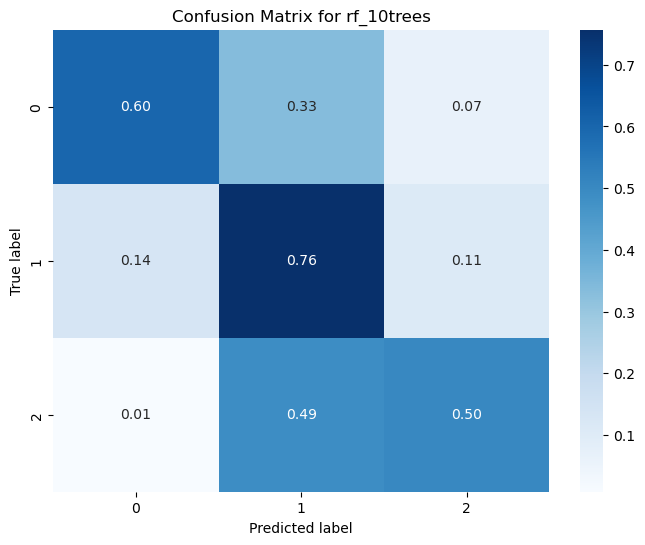

Random Forest (10 trees) Test (accuracy) = 0.6664762176831881
Random Forest (10 trees) Test (f1) = 0.6638156414285838
Random Forest (10 trees) Test (weightedPrecision) = 0.6655797920379609
Random Forest (10 trees) Test (weightedRecall) = 0.6664762176831882
--------------------------------------------------------------------------------------
Running RandomForst with num trees: 20 | name: rf_20trees


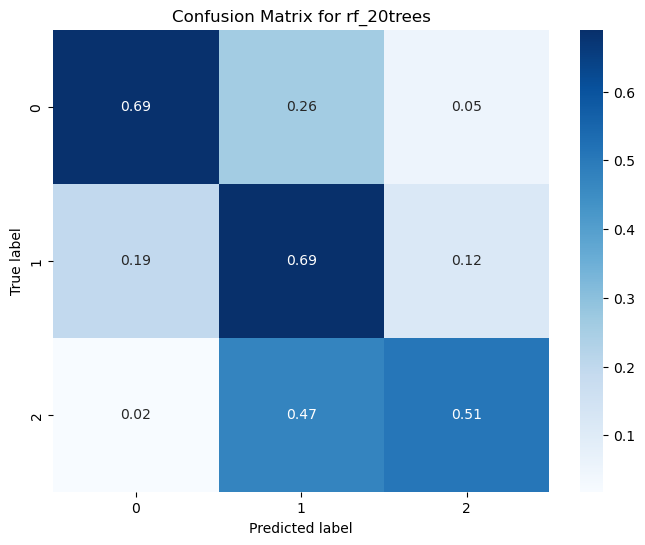

Random Forest (20 trees) Test (accuracy) = 0.6564300338046946
Random Forest (20 trees) Test (f1) = 0.6557970100996529
Random Forest (20 trees) Test (weightedPrecision) = 0.6555511496068357
Random Forest (20 trees) Test (weightedRecall) = 0.6564300338046946
--------------------------------------------------------------------------------------
Running RandomForst with num trees: 30 | name: rf_30trees


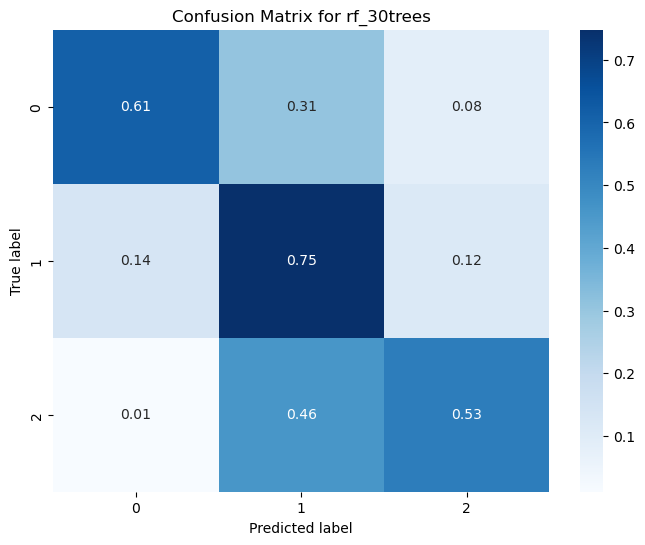

Random Forest (30 trees) Test (accuracy) = 0.6694757891729753
Random Forest (30 trees) Test (f1) = 0.6684139371473519
Random Forest (30 trees) Test (weightedPrecision) = 0.6701434334507975
Random Forest (30 trees) Test (weightedRecall) = 0.6694757891729753
--------------------------------------------------------------------------------------
Running RandomForst with num trees: 40 | name: rf_40trees


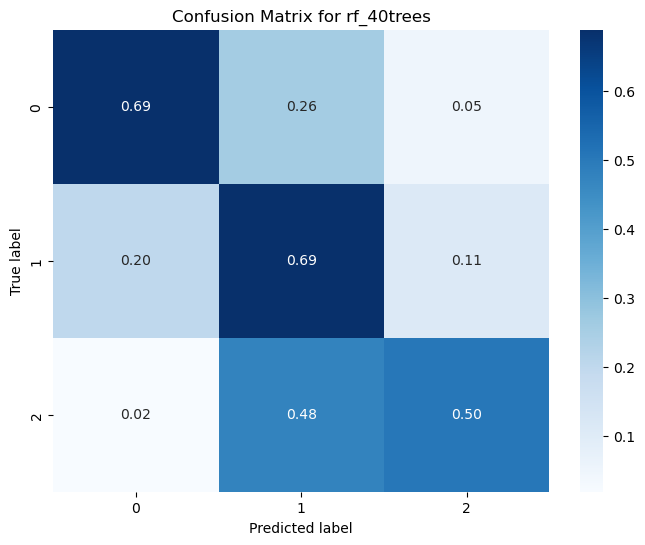

Random Forest (40 trees) Test (accuracy) = 0.655192115412084
Random Forest (40 trees) Test (f1) = 0.6543832638880569
Random Forest (40 trees) Test (weightedPrecision) = 0.6542468370772603
Random Forest (40 trees) Test (weightedRecall) = 0.6551921154120839


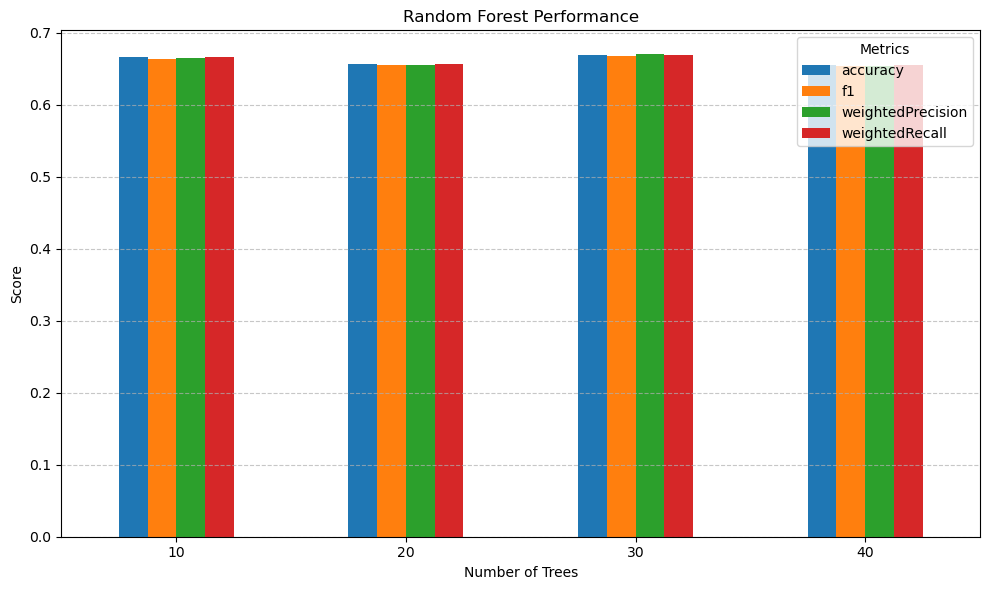

In [13]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import matplotlib.pyplot as plt
import pandas as pd

trees_to_test = [10, 20, 30, 40]
metrics = ["accuracy", "f1", "weightedPrecision", "weightedRecall"]

# Initialize an empty list to collect evaluation results
results = []

# Loop over trees_to_test and metrics as in the original code
for t_num in trees_to_test:
    model_name = f"rf_{t_num}trees"
    print("--------------------------------------------------------------------------------------")
    print(f"Running RandomForst with num trees: {t_num} | name: {model_name}")
    
    rf = RandomForestClassifier(featuresCol='scaledFeatures',
                                labelCol='Credit_score_num',
                                numTrees=t_num)
    rf_model = rf.fit(train_data)
    rf_model.save(f"{models_paths}/RandomForest/{model_name}")
    
    rf_predictions = rf_model.transform(test_data)
    pd_predictions = rf_predictions.select(['prediction', 'Credit_score_num']).toPandas() # aesier to plot with pandas
    plot_confusion_matrix(pd_predictions['Credit_score_num'], pd_predictions['prediction'], model_name) # Send results to confusion matirx
    
    for metric in metrics:
        evaluator = MulticlassClassificationEvaluator(labelCol='Credit_score_num',
                                                      predictionCol='prediction',
                                                      metricName=metric)
        rf_eval = evaluator.evaluate(rf_predictions)
        print(f"Random Forest ({t_num} trees) Test ({metric}) = {rf_eval}")
        
        results.append((t_num, metric, rf_eval))

# Convert results to a pd.DataFrame
results_df = pd.DataFrame(results, columns=["Num_Trees", "Metric", "Score"])

#pivot data for ploting
pivot_df = results_df.pivot(index='Num_Trees', columns='Metric', values='Score')

# Plotting
pivot_df.plot(kind='bar', figsize=(10, 6))
plt.title("Random Forest Performance")
plt.xlabel("Number of Trees")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title="Metrics")
plt.tight_layout()
plt.show()


### Principal features

In [14]:
# Get original feature names from metadata:
metadata = transformed_df.schema['features'].metadata
attrs = metadata['ml_attr']['attrs']

features_info = []

# extract attrs info
for attr_type in ['numeric', 'binary']:
    if attr_type in attrs:
        features_info.extend(attrs[attr_type])

# sort by index
features_info = sorted(features_info, key=lambda x: x['idx'])

# Get imporantace from model (rf_is the last RF model created in the previous loop - 40 trees)
importances = rf_model.featureImportances

# Match feature names with their importances
feature_importance_list = [(f['name'], importances[f['idx']]) for f in features_info]
feature_importance_list

[('Month_num', 0.001333922931636572),
 ('Age', 0.0005711601549365344),
 ('Annual_Income', 0.003514250138716363),
 ('Monthly_Inhand_Salary', 0.0038444677869242288),
 ('Occupation_oneHot_Lawyer', 4.397741611026972e-06),
 ('Occupation_oneHot_Engineer', 0.0),
 ('Occupation_oneHot_Scientist', 0.0),
 ('Occupation_oneHot_Architect', 1.7936435276507698e-05),
 ('Occupation_oneHot_Developer', 1.884800198501543e-05),
 ('Occupation_oneHot_Accountant', 2.9041431883404868e-05),
 ('Occupation_oneHot_Mechanic', 2.0473383734779628e-05),
 ('Occupation_oneHot_Entrepreneur', 1.8205277017599427e-05),
 ('Occupation_oneHot_Teacher', 0.0),
 ('Occupation_oneHot_Media_Manager', 6.767060263789091e-06),
 ('Occupation_oneHot_Journalist', 7.766037315295135e-05),
 ('Occupation_oneHot_Doctor', 1.759224383334436e-05),
 ('Occupation_oneHot_Manager', 2.0433048906320863e-05),
 ('Occupation_oneHot_Musician', 1.3549634753120596e-05),
 ('Occupation_oneHot_Writer', 3.047081421895685e-05),
 ('Occupation_oneHot_NA', 0.0),
 ('N

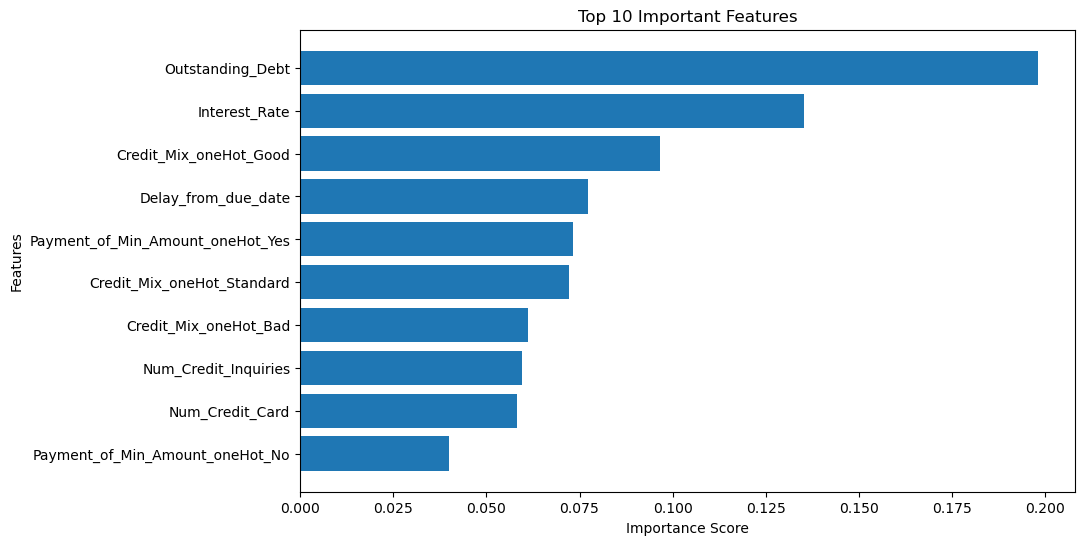

In [15]:
import matplotlib.pyplot as plt

# Sort the features by importance
sorted_features = sorted(feature_importance_list, key=lambda x: x[1], reverse=True)

# Select top N features you want to display
top_n = 10
top_features, top_scores = zip(*sorted_features[:top_n])

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.barh(range(top_n), top_scores, align='center')
plt.yticks(range(top_n), top_features)
plt.gca().invert_yaxis()  # Invert y-axis to have the most important at the top
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Top 10 Important Features')
plt.show()

## MultiLayerPercepton

In [16]:
feature_vector = train_data.select("scaledFeatures").first()[0]
print(f"Feature vector len: {len(feature_vector)}")

Feature vector len: 57


--------------------------------------------------------------------------------------
Running MultilayerPerceptronClassifier with config: [57, 20, 10, 3] | config: 1 | name: MLP_config_1


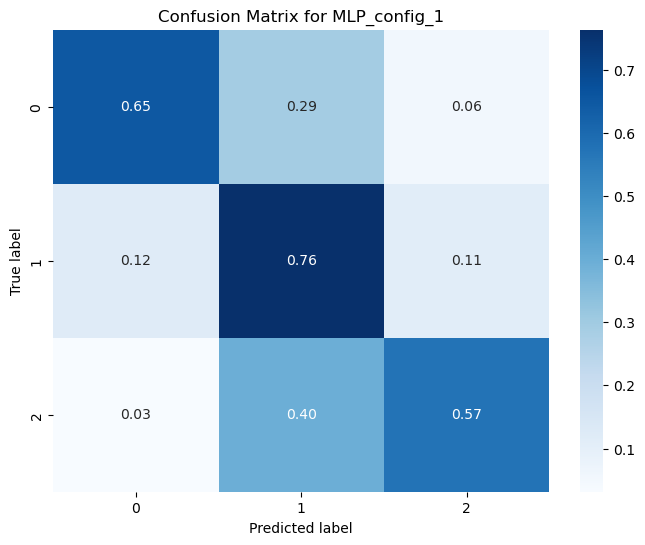

Neural Network ([57, 20, 10, 3]) Test (accuracy) = 0.6968528305480169
Neural Network ([57, 20, 10, 3]) Test (f1) = 0.6961172165739236
Neural Network ([57, 20, 10, 3]) Test (weightedPrecision) = 0.6972420595370785
Neural Network ([57, 20, 10, 3]) Test (weightedRecall) = 0.6968528305480169
--------------------------------------------------------------------------------------
Running MultilayerPerceptronClassifier with config: [57, 30, 20, 3] | config: 2 | name: MLP_config_2


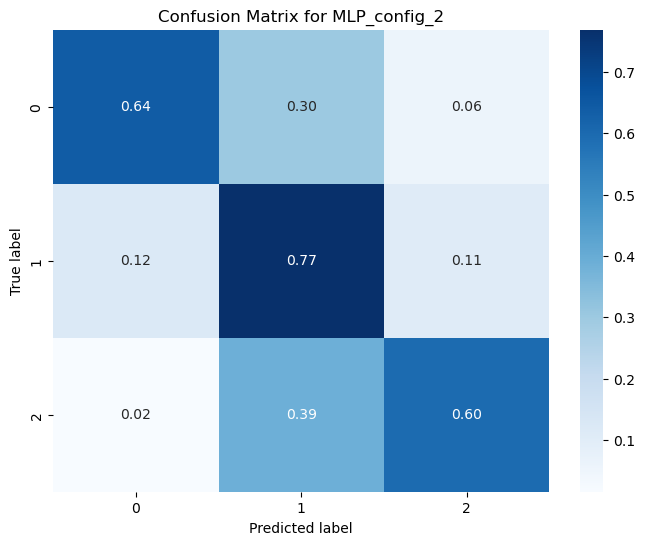

Neural Network ([57, 30, 20, 3]) Test (accuracy) = 0.7007094224634576
Neural Network ([57, 30, 20, 3]) Test (f1) = 0.6998267806612926
Neural Network ([57, 30, 20, 3]) Test (weightedPrecision) = 0.701591854967105
Neural Network ([57, 30, 20, 3]) Test (weightedRecall) = 0.7007094224634576
--------------------------------------------------------------------------------------
Running MultilayerPerceptronClassifier with config: [57, 40, 30, 3] | config: 3 | name: MLP_config_3


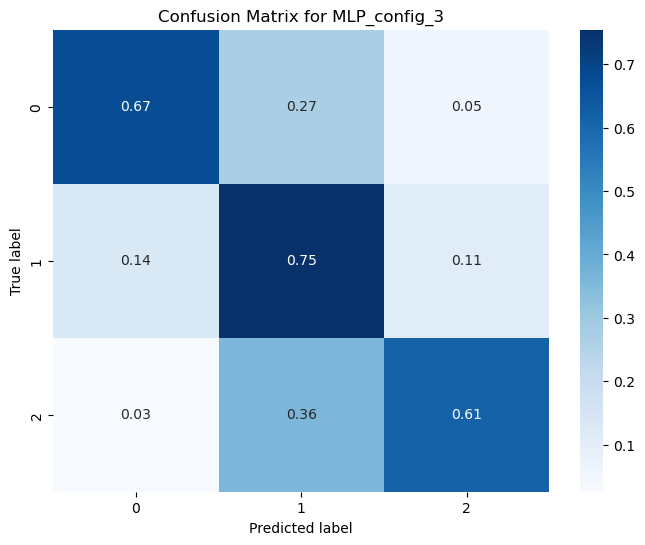

Neural Network ([57, 40, 30, 3]) Test (accuracy) = 0.7064228919678142
Neural Network ([57, 40, 30, 3]) Test (f1) = 0.7063502648007842
Neural Network ([57, 40, 30, 3]) Test (weightedPrecision) = 0.7068223588223602
Neural Network ([57, 40, 30, 3]) Test (weightedRecall) = 0.706422891967814


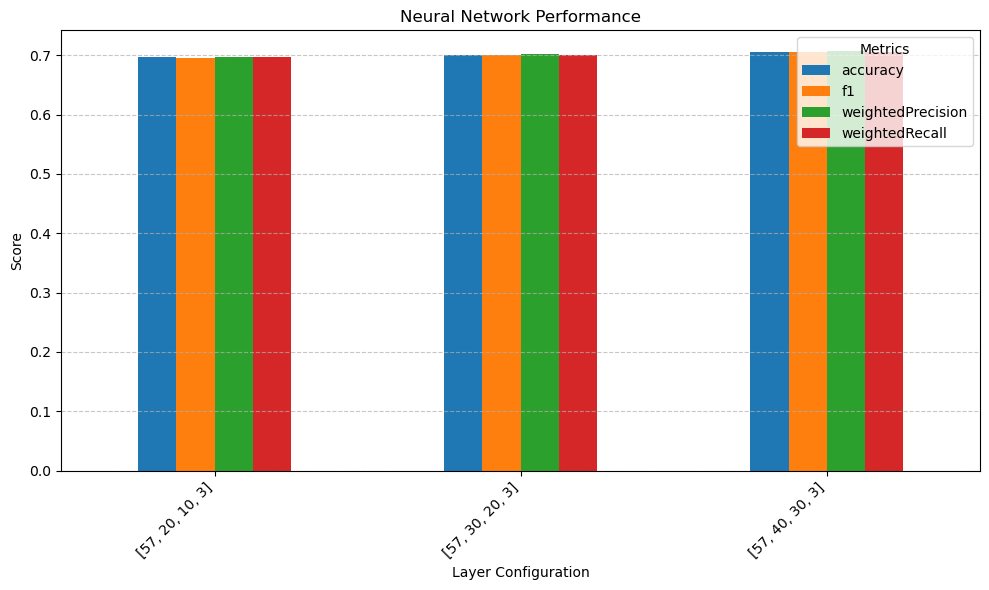

In [17]:
# https://spark.apache.org/docs/latest/ml-classification-regression.html#multilayer-perceptron-classifier
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import pandas as pd
import matplotlib.pyplot as plt

# Layers to test
layer_configurations = [[len(feature_vector), 20, 10, 3], # input, hidden, hidden, output
                        [len(feature_vector), 30, 20, 3],
                        [len(feature_vector), 40, 30, 3]
                        ]

metrics = ["accuracy", "f1", "weightedPrecision", "weightedRecall"]
results = []

for count, layers in enumerate(layer_configurations, start=1):
    model_name = f"MLP_config_{count}"
    print("--------------------------------------------------------------------------------------")
    print(f"Running MultilayerPerceptronClassifier with config: {layers} | config: {count} | name: {model_name}")
    
    # Init classifier
    nn = MultilayerPerceptronClassifier(featuresCol='scaledFeatures',
                                        labelCol='Credit_score_num',
                                        layers=layers,
                                        blockSize=128,
                                        seed=1234,
                                        maxIter=300)
    
    # fit model + save
    nn_model = nn.fit(train_data)
    nn_model.save(f"{models_paths}/MultilayerPerceptron/{model_name}")

    # Make predicts of test data
    nn_predictions = nn_model.transform(test_data)
    pd_predictions = nn_predictions.select(['prediction', 'Credit_score_num']).toPandas() # aesier to plot with pandas
    plot_confusion_matrix(pd_predictions['Credit_score_num'], pd_predictions['prediction'], model_name) # Send results to confusion matirx
    
    # Evaluate model
    for metric in metrics:
        evaluator = MulticlassClassificationEvaluator(labelCol='Credit_score_num',
                                                      predictionCol='prediction',
                                                      metricName=metric)
        nn_eval = evaluator.evaluate(nn_predictions)
        print(f"Neural Network ({layers}) Test ({metric}) = {nn_eval}")
        
        # Append results to the list
        results.append((str(layers), metric, nn_eval))

# Convert results to a DataFrame
results_df = pd.DataFrame(results, columns=["Layers", "Metric", "Score"])

# Pivot the DataFrame to make it suitable for plotting
pivot_df = results_df.pivot(index='Layers', columns='Metric', values='Score')

# Plotting
pivot_df.plot(kind='bar', figsize=(10, 6))
plt.title("Neural Network Performance")
plt.xlabel("Layer Configuration")
plt.ylabel("Score")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title="Metrics")
plt.tight_layout()
plt.show()

## Multinomial logistic regression

--------------------------------------------------------------------------------------
Running Logistic Regression with regularization: 0.0 | name: logistic_0.0reg


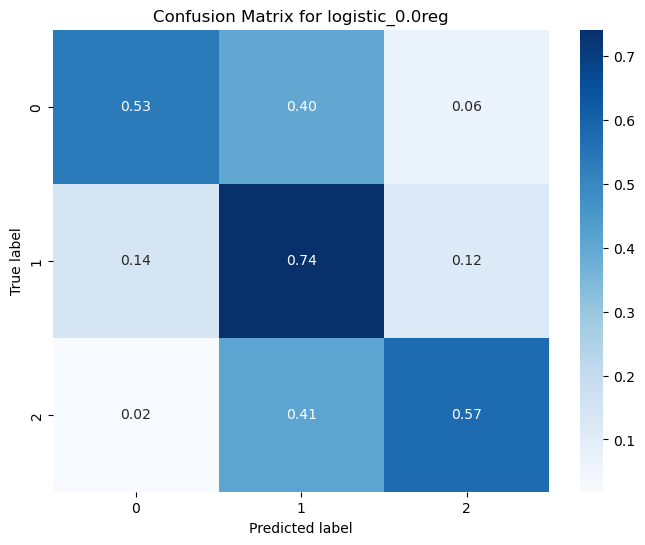

Logistic Regression (0.0 regularization) Test (accuracy) = 0.6508594010379469
Logistic Regression (0.0 regularization) Test (f1) = 0.6480240358017763
Logistic Regression (0.0 regularization) Test (weightedPrecision) = 0.6510153986826688
Logistic Regression (0.0 regularization) Test (weightedRecall) = 0.6508594010379469
--------------------------------------------------------------------------------------
Running Logistic Regression with regularization: 0.1 | name: logistic_0.1reg


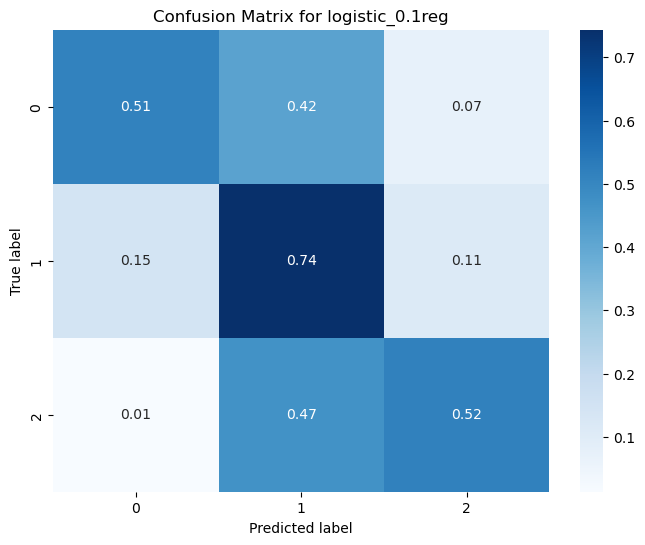

Logistic Regression (0.1 regularization) Test (accuracy) = 0.636528115031186
Logistic Regression (0.1 regularization) Test (f1) = 0.6321834205955279
Logistic Regression (0.1 regularization) Test (weightedPrecision) = 0.6354386339803638
Logistic Regression (0.1 regularization) Test (weightedRecall) = 0.636528115031186
--------------------------------------------------------------------------------------
Running Logistic Regression with regularization: 0.5 | name: logistic_0.5reg


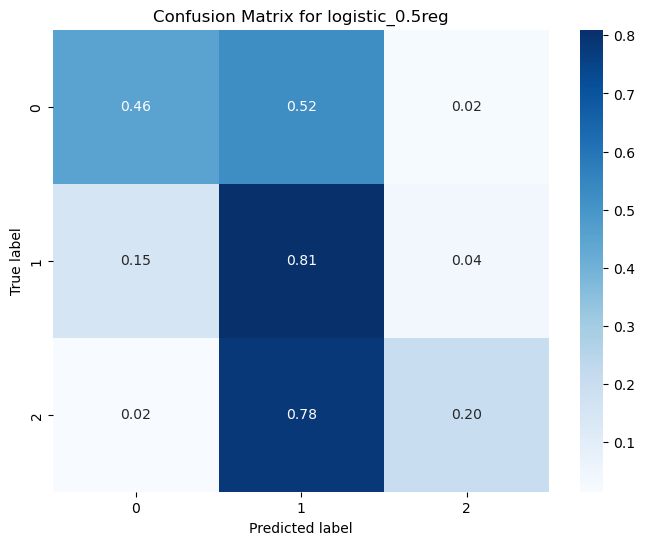

Logistic Regression (0.5 regularization) Test (accuracy) = 0.5991525020235204
Logistic Regression (0.5 regularization) Test (f1) = 0.5709703224375724
Logistic Regression (0.5 regularization) Test (weightedPrecision) = 0.5963124305420027
Logistic Regression (0.5 regularization) Test (weightedRecall) = 0.5991525020235204
--------------------------------------------------------------------------------------
Running Logistic Regression with regularization: 1.0 | name: logistic_1.0reg


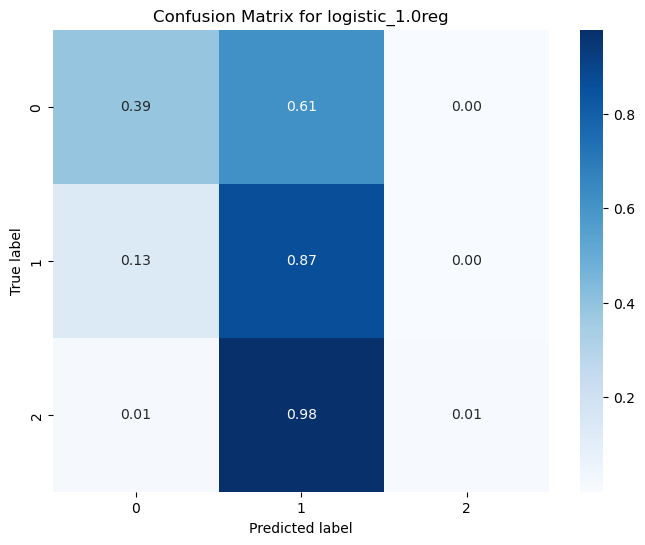

Logistic Regression (1.0 regularization) Test (accuracy) = 0.5747274198923963
Logistic Regression (1.0 regularization) Test (f1) = 0.5051897050808937
Logistic Regression (1.0 regularization) Test (weightedPrecision) = 0.5973678531263962
Logistic Regression (1.0 regularization) Test (weightedRecall) = 0.5747274198923964


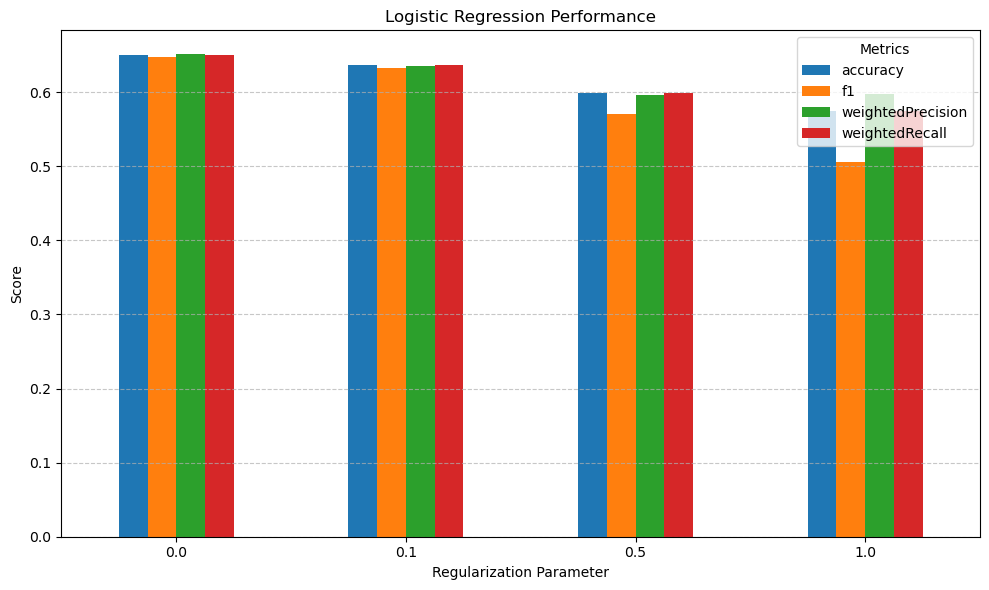

In [18]:
# https://spark.apache.org/docs/latest/ml-classification-regression.html#multinomial-logistic-regression
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import matplotlib.pyplot as plt
import pandas as pd

reg_params = [0.0, 0.1, 0.5, 1.0]  # Regularization parameters to test
metrics = ["accuracy", "f1", "weightedPrecision", "weightedRecall"]

# Initialize an empty list to collect evaluation results
results = []

# Loop over reg_params and metrics
for reg in reg_params:
    model_name = f"logistic_{reg}reg"
    print("--------------------------------------------------------------------------------------")
    print(f"Running Logistic Regression with regularization: {reg} | name: {model_name}")
    
    lr = LogisticRegression(featuresCol='scaledFeatures',
                            labelCol='Credit_score_num',
                            regParam=reg,
                            family="multinomial")  # multiclass
    lr_model = lr.fit(train_data)
    lr_model.save(f"{models_paths}/LogisticRegression/{model_name}")
    
    lr_predictions = lr_model.transform(test_data)
    pd_predictions = lr_predictions.select(['prediction', 'Credit_score_num']).toPandas()  # easier to plot with pandas
    plot_confusion_matrix(pd_predictions['Credit_score_num'], pd_predictions['prediction'], model_name)  # Send results to confusion matrix
    
    for metric in metrics:
        evaluator = MulticlassClassificationEvaluator(labelCol='Credit_score_num',
                                                      predictionCol='prediction',
                                                      metricName=metric)
        lr_eval = evaluator.evaluate(lr_predictions)
        print(f"Logistic Regression ({reg} regularization) Test ({metric}) = {lr_eval}")
        
        results.append((reg, metric, lr_eval))

# Convert results to a pd.DataFrame
results_df = pd.DataFrame(results, columns=["RegParam", "Metric", "Score"])

# Pivot data for plotting
pivot_df = results_df.pivot(index='RegParam', columns='Metric', values='Score')

# Plotting
pivot_df.plot(kind='bar', figsize=(10, 6))
plt.title("Logistic Regression Performance")
plt.xlabel("Regularization Parameter")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title="Metrics")
plt.tight_layout()
plt.show()


# PCA

None of the models were actually good

Random Forest with 40 was the least bad model. We'll try to improve it with PCA

## MLP

--------------------------------------------------------------------------------------
Running MultilayerPerceptron with PCA: k=5 | name: mlp_pca_k5


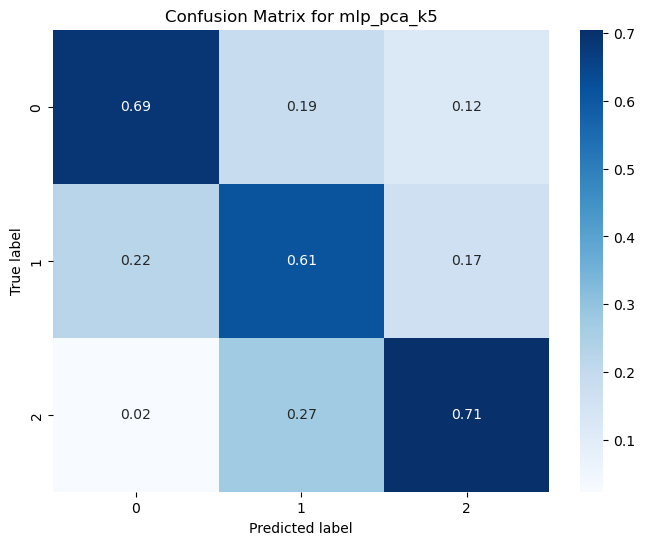

MLP (k=5) Test (accuracy) = 0.6504785030709899
MLP (k=5) Test (f1) = 0.6540892998035998
MLP (k=5) Test (weightedPrecision) = 0.6732279171393181
MLP (k=5) Test (weightedRecall) = 0.6504785030709899
--------------------------------------------------------------------------------------
Running MultilayerPerceptron with PCA: k=10 | name: mlp_pca_k10


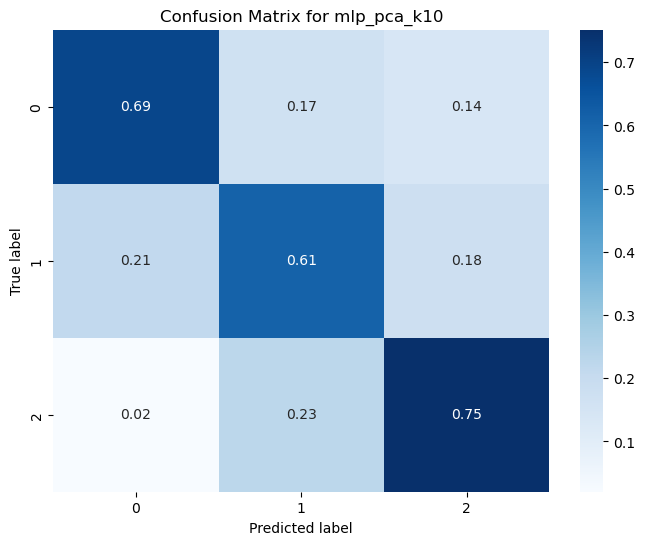

MLP (k=10) Test (accuracy) = 0.657953625672523
MLP (k=10) Test (f1) = 0.6623147221663153
MLP (k=10) Test (weightedPrecision) = 0.6881731134037461
MLP (k=10) Test (weightedRecall) = 0.6579536256725229
--------------------------------------------------------------------------------------
Running MultilayerPerceptron with PCA: k=15 | name: mlp_pca_k15


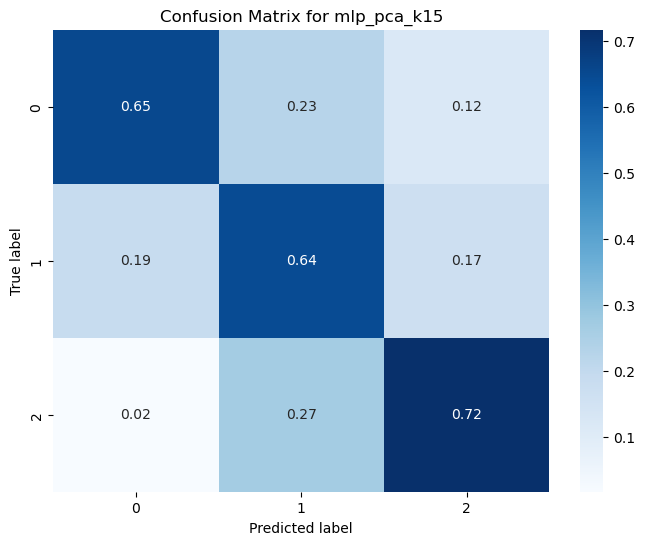

MLP (k=15) Test (accuracy) = 0.6593819930486121
MLP (k=15) Test (f1) = 0.6631881485454616
MLP (k=15) Test (weightedPrecision) = 0.678017342020281
MLP (k=15) Test (weightedRecall) = 0.6593819930486121
--------------------------------------------------------------------------------------
Running MultilayerPerceptron with PCA: k=20 | name: mlp_pca_k20


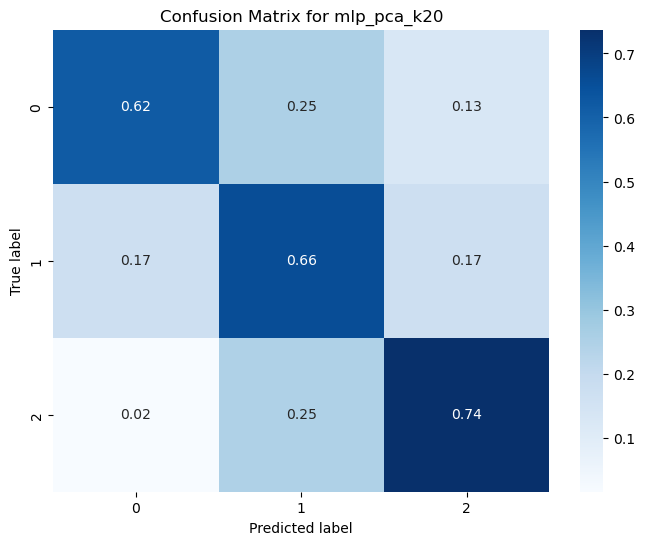

MLP (k=20) Test (accuracy) = 0.6588106460981764
MLP (k=20) Test (f1) = 0.6624968853429771
MLP (k=20) Test (weightedPrecision) = 0.6776896219514488
MLP (k=20) Test (weightedRecall) = 0.6588106460981764
--------------------------------------------------------------------------------------
Running MultilayerPerceptron with PCA: k=25 | name: mlp_pca_k25


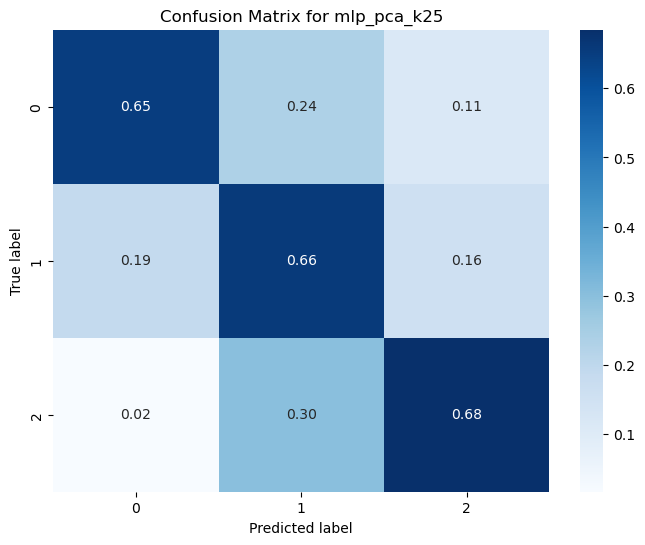

MLP (k=25) Test (accuracy) = 0.6603818502118745
MLP (k=25) Test (f1) = 0.6638128409525343
MLP (k=25) Test (weightedPrecision) = 0.6745002420465086
MLP (k=25) Test (weightedRecall) = 0.6603818502118746


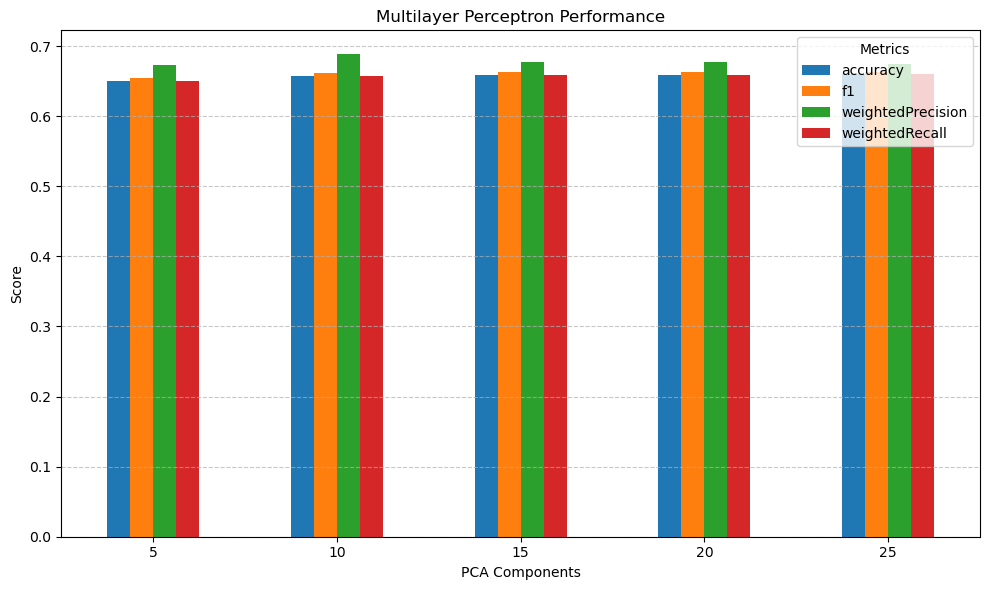

In [19]:
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import PCA
import pandas as pd

k_values = [5, 10, 15, 20, 25]
results = []

for k_val in k_values:
    model_name = f"mlp_pca_k{k_val}"
    print("--------------------------------------------------------------------------------------")
    print(f"Running MultilayerPerceptron with PCA: k={k_val} | name: {model_name}")
    
    # Define PCA
    pca = PCA(k=k_val, inputCol="scaledFeatures", outputCol="pcaFeatures")
    pca_model = pca.fit(transformed_df)
    pca_transformed_df = pca_model.transform(transformed_df)
    
    # Split the data
    pca_train_data, pca_test_data = pca_transformed_df.randomSplit([0.8, 0.2], seed=123)
    
    # Define the layers for the neural network:
    layers = [k_val, 40, 30, 3]

    # Create the trainer and set its parameters
    mlp = MultilayerPerceptronClassifier(layers=layers, featuresCol='pcaFeatures', labelCol='Credit_score_num', blockSize=128, seed=1234)
    
    # Train the model
    mlp_model = mlp.fit(pca_train_data)
    mlp_model.save(f"{models_paths}/MLP/{model_name}")
    
    # Compute predictions
    mlp_predictions = mlp_model.transform(pca_test_data)
    
    # Convert to Pandas for plotting
    pca_pd_predictions = mlp_predictions.select(['prediction', 'Credit_score_num']).toPandas()
    
    # Plot the confusion matrix
    plot_confusion_matrix(pca_pd_predictions['Credit_score_num'], pca_pd_predictions['prediction'], model_name)
    
    # Evaluate the model
    for metric in metrics:
        evaluator = MulticlassClassificationEvaluator(labelCol='Credit_score_num', predictionCol='prediction', metricName=metric)
        mlp_eval = evaluator.evaluate(mlp_predictions)
        print(f"MLP (k={k_val}) Test ({metric}) = {mlp_eval}")
        
        results.append((k_val, metric, mlp_eval))

# Convert results to a pd.DataFrame
results_df = pd.DataFrame(results, columns=["K_value", "Metric", "Score"])

# Pivot data for plotting
pivot_df = results_df.pivot(index='K_value', columns='Metric', values='Score')

# Plotting
pivot_df.plot(kind='bar', figsize=(10, 6))
plt.title("Multilayer Perceptron Performance")
plt.xlabel("PCA Components")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title="Metrics")
plt.tight_layout()
plt.show()


In [20]:
spark.stop()